In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
import wuml
import numpy as np
import torch
import torch
import torch.nn as nn

In [4]:
def costFunction(x, x̂, ẙ, y, ŷ, ind):	
#	x -> encoder -> x̂
#	x̂ -> encoder_linear_output -> ẙ	
#	x̂ -> decoder -> ŷ	
#	possible autoencoder objective λ could be 0
#	loss = (x - ŷ)ᒾ + λ * objective(ẙ, y)
#
#	This function can return 1 value or 3 values in a list
#	if return 1 value, just the loss
#	if return 3 values, [total_loss, reconstruction_loss, extra network from ẙ loss]
#
#	In this example, we perform both reconstruction and CE loss
#
	CE_loss = nn.CrossEntropyLoss() #weird pytorch, dim of y is 1, and ŷ is 20x3
	R = torch.sum((x - ŷ) ** 2)/(128*13)	#scaled by batch size times data dimension
	mse = torch.sum((ẙ - y) ** 2)/(128)	#scaled by batch size times data dimension
	loss = R + mse
	return [loss, R, mse]

In [5]:
def costFunction2(x, x̂, ẙ, y, ŷ, ind):	
#	Example of just return 1 value, this is just a regular autoencoder
	return torch.sum((x - ŷ) ** 2)

In [6]:
data = wuml.wData('../../data/shap_regress_example_uniform.csv', label_column_name='label', label_type='continuous', 
				preprocess_data='center and scale',	first_row_is_label=True)

In [7]:
[X_train, X_test, y_train, y_test] = wuml.split_training_test(data, test_percentage=0.2)

In [8]:
AE = wuml.autoencoder(12, X_train, default_depth=2, costFunction=costFunction, # costFunction and costFunction2 both works
						max_epoch=1000, encoder_output_weight_structure=[(1,'none')] ) 
AE.fit()

	epoch: 1000, Total Loss/dimension: 0.2637, Reconstruct loss: 0.0060, Objective loss: 0.2577, Learning Rate: 0.00000024

Result of the data reconstruction

In [9]:
ŷ = AE(data)
wuml.jupyter_print('\n\n')
recontructed = wuml.pretty_np_array(ŷ[0:5,0:5], front_tab='', title='recontruction')
original = wuml.pretty_np_array(data.X[0:5,0:5], front_tab=' ', title='original')
wuml.block_two_string_concatenate(recontructed, original, spacing='\t', auto_print=True)

        recontruction        	original           
[ 0.     1.     2.     3.   ]	 [ 0.     1.     2.     3.   ]
[ 0.21   1.07   0.223  0.331]	 [ 0.109  0.853  0.292  0.279]
[-0.182  0.747 -0.199  1.168]	 [-0.341  0.591 -0.303  1.388]
[ 1.364 -0.587  0.478  0.812]	 [ 1.6   -0.402  0.972  0.228]
[ 0.365  1.843 -1.956 -0.911]	 [ 0.178  1.648 -1.623 -1.184]
[-1.401  1.908  1.62   0.55 ]	 [-1.792  1.297  0.924  1.318]
                             	



This is the bottleneck output which is d=12

In [10]:
x̂ = AE.reduce_dimension(data, output_type='wData')
wuml.jupyter_print(x̂)
wuml.jupyter_print('\n')

This is the objective network output Training error

Avg error: 0.9608

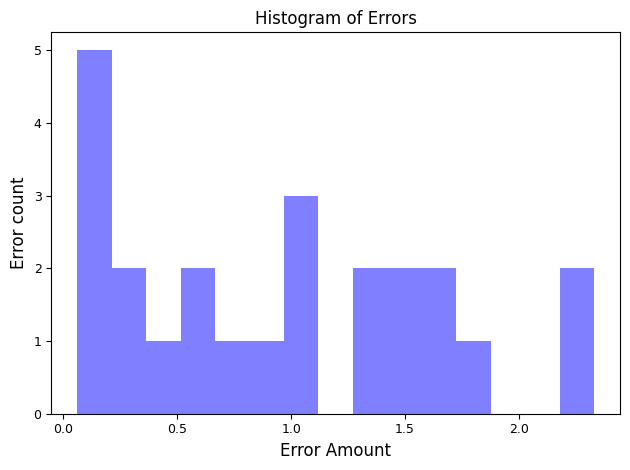

In [11]:
ẙ = AE.objective_network(X_train)
res = wuml.output_regression_result(y_train, ẙ, sort_by='error')

This is the objective network output Test error

Avg error: 0.6100

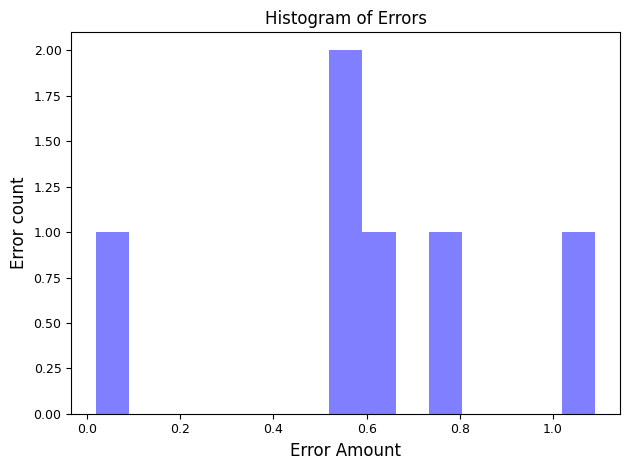

In [12]:
ẙ = AE.objective_network(X_test)
res = wuml.output_regression_result(y_test, ẙ, sort_by='error')